In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# *Loading the data*

In [3]:
LOCATION_CSV_TRAIN = "/content/gdrive/My Drive/Colab Notebooks/data-sea-ice/DRIFT_DATA_TRAIN.csv"
LOCATION_CSV_TEST = "/content/gdrive/My Drive/Colab Notebooks/data-sea-ice/DRIFT_DATA_TEST.csv"

In [4]:
train = pd.read_csv(LOCATION_CSV_TRAIN)
test = pd.read_csv(LOCATION_CSV_TEST)

# Marking buoy ids found in the same year & day of year

Increasing a counter to mark groups of elements respecting the conditions stated above.

In [5]:
t = 0
year_day_to_t = {}
train['t'] = 0 
test['t'] = 0
for year in sorted(list(train.year.unique())):
    for i in range(370):
        good_date = False
        if len(train[(train['year']==year) & (train['doy']==i)]) > 0:
            train.loc[(train.year==year) & (train.doy==i), 't'] = t
            good_date = True
        if len(test[(test['year']==year) & (test['doy']==i)]) > 0:
            test.loc[(test.year==year) & (test.doy==i), 't'] = t
            good_date = True
        if good_date:
            year_day_to_t[(year, i)] = t
            t += 1
train.to_csv("/content/gdrive/My Drive/Colab Notebooks/data-sea-ice/DRIFT_DATA_TRAIN_T_CONV.csv")
train.head(10)

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c,t
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298,0
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669,0
2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,-8.825469,1.123955,0.996022,NaN,2.474106,362.547379,0
3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,-1.079951,-1.035410,0.982681,NaN,3.740522,381.025629,0
4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,-2.169171,2.537787,0.990302,NaN,3.188522,521.535334,1
5,1979,2,19,50,180.349854,118.013527,1.387772,-0.253256,1911,2.680910,-0.295979,1.000000,NaN,2.574216,475.418633,1
6,1979,2,19,50,146.830490,120.509583,3.025445,1.076415,1913,0.551862,3.960332,1.000000,NaN,2.490376,412.761318,1
7,1979,2,19,50,130.940811,129.619873,1.409495,-0.041150,1914,-1.859920,1.140724,0.979121,NaN,2.480513,361.805709,1
8,1979,2,19,50,164.691742,110.154053,2.601760,2.154950,1925,1.245225,3.909907,0.992524,NaN,2.499613,404.686873,1
9,1979,2,20,51,197.865143,204.957596,-9.593610,-3.266865,1905,-2.742443,2.614781,0.964051,NaN,2.525601,367.538449,2


In [6]:
train.head(2)

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c,t
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298,0
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669,0


# Names of the columns we are interested in

**List of features of interest**

`year, doy, x_EASE, y_EASE, u_buoy, v_buoy, u_ERA5, v_ERA5, sic_CDR, h_piomas, d2c`



In [6]:
# used for scaling
good_columns = ['year', 'doy', 'x_EASE', 'y_EASE', 'u_buoy', 'v_buoy', 'u_ERA5', 'v_ERA5', 'sic_CDR', 'h_piomas', 'd2c']
feature_2 = ['year', 'doy', 'x_EASE', 'y_EASE', 'u_ERA5', 'v_ERA5', 'sic_CDR', 'h_piomas', 'd2c']
outputs = ['u_buoy', 'v_buoy']

In [7]:
column_norm = {}
for col in good_columns:
  column_norm[col] = {
      'std': train[col].std(),
      'mean': train[col].mean(),
  }
  train[col] = (train[col] - column_norm[col]['mean'])/column_norm[col]['std']

In [8]:
max_t_count = train.groupby('t')['id_buoy'].count().max()
max_t_count

148

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, indices, max_t_count, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = dataframe
        self.indices = indices
        self.shuffle = shuffle
        self.max_t_count = max_t_count
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        x1 = np.zeros((self.batch_size, self.max_t_count, len(good_columns)), dtype=np.float32)
        x2 = np.zeros((self.batch_size, len(feature_2)), dtype=np.float32)
        y = np.zeros((self.batch_size, len(outputs)), dtype=np.float32)
       
        for i, id in enumerate(batch):
          tvalues = self.df.loc[self.df.t == id]
          rr = random.randint(0, len(tvalues)-1)
          x = np.zeros((self.max_t_count, len(good_columns)), dtype=np.float32)
          if len(tvalues) > 1:
            x_np = tvalues[~tvalues.index.isin([rr])][good_columns].to_numpy()
            x[:x_np.shape[0],:x_np.shape[1]] = x_np
          x1[i]=np.random.shuffle(x)
          x2[i]=tvalues.iloc[rr][feature_2].to_numpy()
          y[i]=tvalues.iloc[rr][outputs].to_numpy()
        
        return [x1, x2], y

In [10]:
def create_model():
    input_1 = tf.keras.Input(shape=(max_t_count, 11))
    input_2 = tf.keras.Input(shape=(9))

    flatten = tf.keras.layers.Flatten()(input_1)
    dense_1 = tf.keras.layers.Dense(128, activation='sigmoid')(flatten)
    bn_1 = tf.keras.layers.BatchNormalization()(dense_1)
    d_1 = tf.keras.layers.Dropout(0.3)(bn_1)

    dense_2 = tf.keras.layers.Dense(64, activation='relu')(d_1)
    bn_2 = tf.keras.layers.BatchNormalization()(dense_2)
    d_2 = tf.keras.layers.Dropout(0.3)(bn_2)

    dense_input_2 = tf.keras.layers.Dense(64, activation='sigmoid')(input_2)
    concat = tf.keras.layers.concatenate([dense_2, dense_input_2])

    dense_3 = tf.keras.layers.Dense(64, activation='relu')(concat)
    output = tf.keras.layers.Dense(2)(dense_3)

    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    
    return model

In [23]:
model = create_model()
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 148, 11)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1628)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          208512      flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
______________________________________________________________________________________________

In [13]:
bad_ts = set(test['t'].unique()) - set(train['t'].unique())
no_t = len(year_day_to_t)
set_indexs_val = set(np.random.choice(no_t, 1400, replace=False)) - bad_ts
indxs_val = np.array(list(set_indexs_val))
indxs_train = set(range(no_t)) - set_indexs_val
indxs_train = np.array(list(indxs_train - bad_ts))
train_data_gen = DataGenerator(train, indxs_train, max_t_count, batch_size=128, shuffle=True)
val_data_gen = DataGenerator(train, indxs_val, max_t_count, batch_size=128, shuffle=True)

In [22]:
all_train_indices = np.array(list(set(range(no_t)) - bad_ts))
all_train_gen = DataGenerator(train, all_train_indices, max_t_count, batch_size=128, shuffle=True)

In [24]:
history = model.fit(all_train_gen, epochs=60, verbose=1)

Epoch 1/60
112/112 [==============================] - 45s 398ms/step - loss: 0.8338
Epoch 2/60
112/112 [==============================] - 45s 398ms/step - loss: 0.3776
Epoch 3/60
112/112 [==============================] - 45s 398ms/step - loss: 0.3845
Epoch 4/60
112/112 [==============================] - 44s 396ms/step - loss: 0.3334
Epoch 5/60
112/112 [==============================] - 44s 397ms/step - loss: 0.3637
Epoch 6/60
112/112 [==============================] - 45s 404ms/step - loss: 0.3511
Epoch 7/60
112/112 [==============================] - 46s 407ms/step - loss: 0.3192
Epoch 8/60
112/112 [==============================] - 45s 406ms/step - loss: 0.3211
Epoch 9/60
112/112 [==============================] - 44s 395ms/step - loss: 0.3221
Epoch 10/60
112/112 [==============================] - 44s 396ms/step - loss: 0.3385
Epoch 11/60
112/112 [==============================] - 44s 395ms/step - loss: 0.3168
Epoch 12/60
112/112 [==============================] - 44s 397ms/step - lo

KeyError: ignored

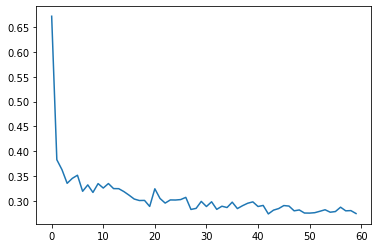

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
tf.keras.models.save_model(model, "/content/gdrive/My Drive/Colab Notebooks/models/sea_ice_naive_perm_60_all")

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/models/sea_ice_naive_perm_60_all/assets


**Sanity Check**


In [ ]:
indxs_val

In [ ]:
indxs_val[4:20]

In [ ]:
to_test = 31
conv_input = np.copy(train_data[to_test])
buoy = train[train['t']==to_test].iloc[5]
conv_input[int(buoy['x_64']), int(buoy['y_64'])] = np.zeros((11))
feature_input = np.array(buoy[feature_2])
buoy[outputs]

In [ ]:
model.predict([np.array([conv_input]), np.array([feature_input])])

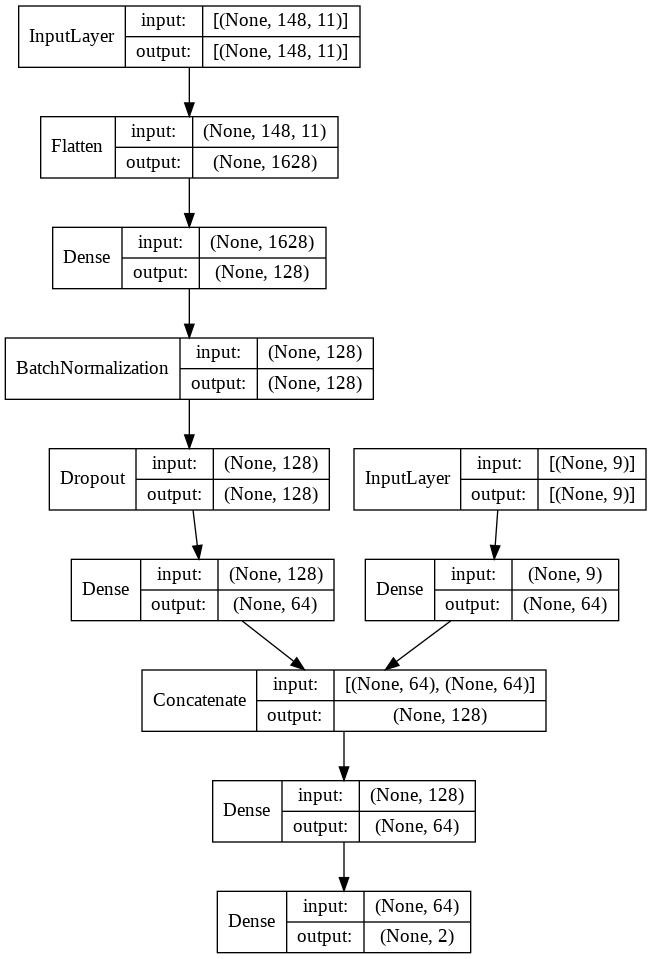

In [27]:
tf.keras.utils.plot_model(
    model, to_file='/content/gdrive/My Drive/Colab Notebooks/model_dense_basic.png', show_shapes=True, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96
)